# Pandeia for Roman

How to cite this code:

> Klaus M. Pontoppidan ; Timothy E. Pickering ; Victoria G. Laidler ; Karoline Gilbert ; Christopher D. Sontag, et al.
"Pandeia: a multi-mission exposure time calculator for JWST and WFIRST", Proc. SPIE 9910, Observatory Operations: Strategies, Processes, and Systems VI, 991016 (July 15, 2016); doi:10.1117/12.2231768; http://dx.doi.org/10.1117/12.2231768

This is an introductory notebook that provides an easy-to-use interface for making Pandeia ETC calculations. The Pandeia engine called by this notebook only supports basic Roman imaging and Spectroscopy modes - the coronagraphic modes are not supported. This notebook has simplified some configuration options to present a summary of the steps most users will take to make Roman calculations. Users are encouraged to view <a href="https://jwst-docs.stsci.edu/display/JPP/JWST+Exposure+Time+Calculator+-+ETC">the JWST documentation</a> for an overview of the features and functionality of the Pandeia engine and an explanation of the quantities calculated by Pandeia.



Refer to the documentation links provided within the *Help* menu for general information on the Jupyter/IPython notebook interface and useful keyboard short-cuts.  The key things you need to know are that you must use ``Shift-Enter`` to execute a cell and that once a cell is executed, all data defined within it becomes available to all other cells. (You can also click the <i class="fa-step-forward fa"></i> icon in the toolbar to run a cell.)

This first cell sets up the imports and configuration that are required:  

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import sys
import os
import numpy as np
import matplotlib
from matplotlib import style
#style.use('ggplot')  # see http://matplotlib.org/users/style_sheets.html
                     # for info on matplotlib styles
import json
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt

# the first pandeia import is required to run calculations. the others are provided to
# allow setting up calculations and loading/saving of inputs or results.
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

To run Pandeia, you must give it a calculation. Calculations are python dictionaries that specify every aspect of the detector configuration, instrument configuration, details of all of the sources in the scene, and observing strategies.

Let's break it down.

# First, we need to create a calculation. 

build_default_calc will create a default calculation for a Roman instrument, complete with a single faint point source.

build_default_calc() takes three arguments: telescope, instrument, mode.

Telescope is (obviously) roman.

Instrument is wfi

The modes available for the WFI are Imaging and Spectroscopy.

To set up default observations for one of these modes, run one of the following cells.

### Roman Imaging

In [2]:
calc = build_default_calc('roman','wfi','imaging')

### Roman Spectroscopy

In [3]:
calc = build_default_calc('roman','wfi','spectroscopy')

We should now have a complete calculation, so we can run it. Try the following, and if it doesn't work, check your setup.

In [4]:
results = perform_calculation(calc)

# Put together a scene of sources to observe

The first thing we need to do is customize the scene. The default that's been created for us is a single central point source with a flat spectral energy distribution, normalized to a flux of 0.001 mjy at 2.0 microns, with no redshift or extinction.

In [5]:
calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.001 # mjy
calc['scene'][0]['spectrum']['normalization']['norm_wave'] = 2.0 # microns
calc['scene'][0]['spectrum']['normalization']['type'] = "at_lambda"

The type of flux normalization can be changed. Run the cell below to normalize to a bandpass
- Valid bandpasses are:
   - bessell,J (or H or K)
   - cousins,I
   - johnson,V (or I, J, K)
   - sdss,u (or g, r, i, or z)
   - spitzer,irac3.6 (or irac4.5, irac5.8, irac8.0, mips24)
- You can also specify 'jwst' or 'hst' instead of 'photsys'; that requires specifying the instrument, detector or mode, and filter ('hst' and 'wfc3,ir,f140w', or 'jwst' and 'miri,imaging,f1280w'...)
   

In [6]:
calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.001 # mjy
calc['scene'][0]['spectrum']['normalization']['norm_wave'] = 2.0 # microns
calc['scene'][0]['spectrum']['normalization']['type'] = "photsys"
calc['scene'][0]['spectrum']['normalization']['bandpass'] = "sdss,z"

There are also other options for the SED, most notably a simple blackbody curve, or phoenix models, or one of the Brown galaxy spectra.

Run one of the following cells if you want to customize your source to a different SED type: 

In [7]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'blackbody' # shape
calc['scene'][0]['spectrum']['sed']['temp'] = 5770.0 # brightness temperature

In [8]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'phoenix' # shape
calc['scene'][0]['spectrum']['sed']['key'] = 'g2v' # spectral type

In [9]:
# brown gives EngineInputError: Unsupported or not yet implemented SED: brown

# calc['scene'][0]['spectrum']['sed']['sed_type'] = 'brown' # shape
# calc['scene'][0]['spectrum']['sed']['key'] = 'ngc_3521' # galaxy profile

We can also change the shape of the source. Valid options are 'point', 'gaussian2d', 'sersic', 'sersic_scale', 'power', and 'flat'. 

- 'point' (the default) is a point source, represented as a simple impulse function to convolve with the PSF.
- 'flat' is an ellipse step function, with a uniform distribution out to the bounding curve.
- 'gaussian2d' is a two-dimensional gaussian function, where major and minor are now the 1-sigma boundaries.
- 'sersic' is the sersic formulation from Graham & Driver (1992) where the semimajor and semiminor axes are for the effective radius.
- 'sersic_scale' is NOT the typical sersic formulation from Graham & Driver (1992); it is an e-folding version, defined as $e^{-r(\frac{1}{index})}$. index=4 is the standard De Vaucoulers profile, index 0.5 is similar to a gaussian, and index=1 is an exponential profile.
- 'power' is a circular power-law profile, whose only options are r_core (radius of a flat central code, in arcseconds) and 'power_index', the power of the power law. The only valid normalization is surf_center.

If you change the shape to gaussian2d, flat, or sersic, you have additional parameters to fill. In particular, there are options to change how you set the source brightness:
 - 'integ_infinity' Integrates the flux of the entire profile
 - 'surf_center' Normalizes to the surface brightness at the center of the profile
 - 'surf_scale' (for gaussian2d and sersic shapes only) Normalizes to the surface brightness at the scale (e-folding for sersic, 1-sigma for gaussian2d) radius.
 
If you choose surf_center or surf_scale, you need to specify whether the brightness is per square arcsecond ('arcsec^2') or per steradian ('sr')

In [10]:
calc['scene'][0]['shape']['geometry'] = 'point' # default

In [11]:
calc['scene'][0]['shape']['geometry'] = 'gaussian2d'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['norm_method'] = 'integ_infinity'
calc['scene'][0]['shape']['surf_area_units'] = None
# The default setup with integ_infinity normalization produces low SNR, so we will set a brighter source
calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.01 # mjy

In [12]:
calc['scene'][0]['shape']['geometry'] = 'flat'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['norm_method'] = 'surf_center'
calc['scene'][0]['shape']['surf_area_units'] = 'arcsec^2'

In [13]:
calc['scene'][0]['shape']['geometry'] = 'sersic'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['sersic_index'] = 1.0
calc['scene'][0]['shape']['norm_method'] = 'surf_scale'
calc['scene'][0]['shape']['surf_area_units'] = 'sr'

In [14]:
calc['scene'][0]['shape']['geometry'] = 'sersic_scale'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['sersic_index'] = 1.0
calc['scene'][0]['shape']['norm_method'] = 'surf_scale'
calc['scene'][0]['shape']['surf_area_units'] = 'sr'

In [15]:
calc['scene'][0]['shape']['geometry'] = 'power'
calc['scene'][0]['shape']['r_core'] = 0.1 # arcsec
calc['scene'][0]['shape']['power_index'] = 1.0
calc['scene'][0]['shape']['norm_method'] = 'surf_center'
calc['scene'][0]['shape']['surf_area_units'] = 'sr'

We can also position the source: (orientation obviously means little to a point source)

In [16]:
calc['scene'][0]['position']['x_offset'] = 0.0 # arcsec
calc['scene'][0]['position']['y_offset'] = 0.0 # arcsec
calc['scene'][0]['position']['orientation'] = 45.0 # degrees

You can also add other sources, and customize them. The scene is a list of sources. The source we've been modifying is the zeroth source; anything you add will be calc['scene'][1] or higher when you customize it.

The two cells below will:

* Add a second source, configured as a point source
* Customize it to be a K0III object at 23rd magnitude through the HST WFC3/IR F098M filter, offset by 1 arcsecond to the east

In [17]:
calc['scene'].append(build_default_source(geometry="point"))

In [18]:
calc['scene'][1]['spectrum']['normalization']['norm_flux'] = 23
calc['scene'][1]['spectrum']['normalization']['norm_fluxunit'] = "vegamag"
calc['scene'][1]['spectrum']['normalization']['type'] = "hst"
calc['scene'][1]['spectrum']['normalization']['bandpass'] = "wfc3,ir,f098m"

calc['scene'][1]['spectrum']['sed']['sed_type'] = 'phoenix' # shape
calc['scene'][1]['spectrum']['sed']['key'] = 'k0iii' # spectral type

calc['scene'][1]['position']['x_offset'] = 1.0 # arcsec
calc['scene'][1]['position']['y_offset'] = 0.0 # arcsec
calc['scene'][1]['position']['orientation'] = 45.0 # degrees

# Now let's set up the instrument.

### Roman Imaging

For Roman Imaging:

- Filters
   - f062 (R-band 0.62 microns)
   - f087 (Z-band 0.87 microns) - the default
   - f106 (Y-band 1.06 microns)
   - f129 (J-band 1.29 microns)
   - f146 (wide-band 1.46 microns)
   - f158 (H-band 1.58 microns)
   - f184 (f-band 1.84 microns)
   - f213 (K-band 2.13 microns)
   
There are no valid dispersive elements, and only one valid aperture: 'imaging'.

The detector can be configured to give multiple exposures in multiple groups and integrations, and set the readmode.

For Roman Imaging, there are a number of readout patterns (these have been taken from NIRCam; the final telescope will have very different readout support:

- Readout Patterns:
   - 'rapid'
   - 'shallow2'
   - 'shallow4'
   - 'bright1'
   - 'bright2'
   - 'medium2'
   - 'medium8'
   - 'deep2' - the default
   - 'deep8'

- And a number of subarrays:
   - 'imaging' (with a frame time of 3.04 seconds) - the default
   - 'defocus_small' (with a frame time of 3.66 seconds)
   - 'defocus_large' (with a frame time of 6.44 seconds)
   
To best approximate readouts as currently envisioned for Roman, we suggest using the following:
- For imaging modes:
  + Subarray: “imaging” which has a frame time of 3.04s
- For spectroscopic modes:
  + subarray: “spectroscopic” which has a frame time of 4.03s

The larger subarrays of “defocus_large” and “defocus_small” are for internal testing only.

* _To approximate the current design for the High Latitude Imaging Survey:_ readout_pattern 'medium8' with Ngroups = 6
* _To approximate the current design for the Exoplanet Microlensing Survey:_ readout_pattern 'shallow2' with Ngroups = 4

In [19]:
calc['configuration']['instrument']['filter'] = "f087"
calc['configuration']['instrument']['aperture'] = "imaging"
calc['configuration']['instrument']['disperser'] = None
calc['configuration']['detector']['ngroup'] = 6 # groups per integration
calc['configuration']['detector']['nint'] = 1 # integrations per exposure
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readout_pattern'] = "medium8"
calc['configuration']['detector']['subarray'] = "imaging"

### Roman Spectroscopy

For Roman Spectroscopy, there is much less to configure. There are no filters, and two dispersers: The grism (g150) and the prism (p120).

* Dispersers:
  * g150 (default)
  * p120
  
The readout pattern options are the same, and the only subarray option is "spectroscopy" (with a frame time of 4.03 seconds)

To approximate the current design for the High Latitude Spectroscopic Survey, we recommend using subarray 'spectroscopy', readout pattern 'medium8', and Ngroups = 13

In [20]:
calc['configuration']['instrument']['filter'] = None
calc['configuration']['instrument']['aperture'] = "spectroscopy"
calc['configuration']['instrument']['disperser'] = "g150"
calc['configuration']['detector']['ngroup'] = 13 # groups per integration
calc['configuration']['detector']['nint'] = 1 # integrations per exposure
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readout_pattern'] = "medium8"
calc['configuration']['detector']['subarray'] = "spectroscopy"

# We can now set up the observing strategy. 

### Roman Imaging
For Roman imaging, there are a few options to set up the location, extraction aperture, and background extraction annulus through which the flux and SNR will be calculated. The only strategy available for the imager is 'imagingapphot' (Imaging Aperture Photometry) which is already set by default.

In [21]:
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['aperture_size'] = 0.2 # radius of extraction aperture, in arcsec
calc['strategy']['sky_annulus'] = [0.4,0.6] # inner and outer radii of background subtraction annulus, in arcsec

### Roman Spectroscopy

For Roman spectroscopy, the only strategy available is 'specapphot' (Aperture Spectral Extraction) and again will already be set. 

The rest of the options are quite similar to the imager options, with the addition of a reference wavelength at which you want the flux and SNR to be calculated for the numerical results. If it is set to None, Pandeia will choose the central wavelength of the disperser.

In [22]:
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['aperture_size'] = 0.16 # radius of extraction aperture, in arcsec
calc['strategy']['sky_annulus'] = [0.24,0.64] # inner and outer radii of background subtraction annulus, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 1.35 and 1.89 microns, non-inclusive)

# Calculate!

We now have a formatted calculation we can run, so let's do that.

In [23]:
results = perform_calculation(calc)

Let's unpack the results.  Run the following to see the basic outputs - flux, SNR, exposure time, etc. If the SNR is extremely low, check your source normalization, or increase the number of groups or exposures.

In [24]:
# print the scalar products with what (I think) are the correct units.
print("------------------\n     RESULTS    \n------------------")
for x in sorted(results["scalar"]):
    basename = "{:20}: {}"
    if "time" in x:
        basename += " sec"
    elif "size" in x or "offset" in x:
        basename += " arcsec"
    elif "area" in x:  # checking this before background means the
                       # background_area will be given the correct units.
        basename += " pixel^2"
    elif "wavelength" in x:
        basename += " microns"
    elif (("extracted" in x) or ("sky" in x)) or ("total" in x):
        basename += " e-/sec"
    elif "background" in x:
        basename += " MJy/sr"
    else:
        pass
    print(basename.format(x,results["scalar"][x]))

# also print out the value and location of the best SNR
bestsn = np.argmax(results["1d"]["sn"][1])
print("------------------")
print("Highest SNR: {:.3f} at {:.3f} microns".format(results["1d"]["sn"][1][bestsn], results["1d"]["sn"][0][bestsn]))
if len(results['warnings']) > 0:
    print("----------------\n  WARNINGS  \n----------------")
    for x in results['warnings']:
        print("{:20}: {}".format(x,results['warnings'][x]))

------------------
     RESULTS    
------------------
all_dithers_time    : 519.87 sec
aperture_size       : 0.16 arcsec
background          : 0.16264618841038891 MJy/sr
background_area     : 7.272727272727268 pixel^2
background_sky      : 4.223877869531155 e-/sec
background_total    : 4.226168917625014 e-/sec
brightest_pixel     : 1.4823631123376426
contamination       : 0.0005421099200042804
cr_ramp_rate        : 0.012633879167918811
disperser           : g150
duty_cycle          : 0.9302325581395349
exposure_time       : 519.87 sec
extracted_flux      : 0.03175640571960115 e-/sec
extracted_noise     : 0.11593834947077916 e-/sec
extraction_area     : 2.9090909090909163 pixel^2
filter              : None
fraction_saturation : 0.01274436979780416
measurement_time    : 483.6 sec
reference_wavelength: 1.4693156073339915 microns
sat_ngroups         : 1004.0
saturation_time     : 515.84 sec
sn                  : 0.273907692015272
total_exposure_time : 519.87 sec
total_integrations  : 1 e-

Let's also look at some plots. Here are the detector SNR, signal, and saturation

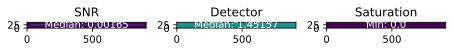

In [25]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(131)
ax2 = fig1.add_subplot(132)
ax3 = fig1.add_subplot(133)
ax1.imshow(results['2d']['snr'])
ax2.imshow(results['2d']['detector'])
ax3.imshow(results['2d']['saturation'])
ax1.set_title('SNR')
ax2.set_title('Detector')
ax3.set_title('Saturation')
ax1.text(0.5,0.95,'Mean: {0:6.5f}'.format(np.mean(results['2d']['snr'])),horizontalalignment='center',transform=ax1.transAxes,color='#FFFFFF')
ax1.text(0.5,0.05,'Median: {0:6.5f}'.format(np.median(results['2d']['snr'])),horizontalalignment='center',transform=ax1.transAxes,color='#FFFFFF')
ax2.text(0.5,0.95,'Mean: {0:6.5f}'.format(np.mean(results['2d']['detector'])),horizontalalignment='center',transform=ax2.transAxes,color='#FFFFFF')
ax2.text(0.5,0.05,'Median: {0:6.5f}'.format(np.median(results['2d']['detector'])),horizontalalignment='center',transform=ax2.transAxes,color='#FFFFFF')
ax3.text(0.5,0.95,'Max: {0:}'.format(np.max(results['2d']['saturation'])),horizontalalignment='center',transform=ax3.transAxes,color='#FFFFFF')
ax3.text(0.5,0.05,'Min: {0:}'.format(np.min(results['2d']['saturation'])),horizontalalignment='center',transform=ax3.transAxes,color='#FFFFFF')
fig1.tight_layout()

We can also see some 1D plots. They won't look like much in Imager mode.

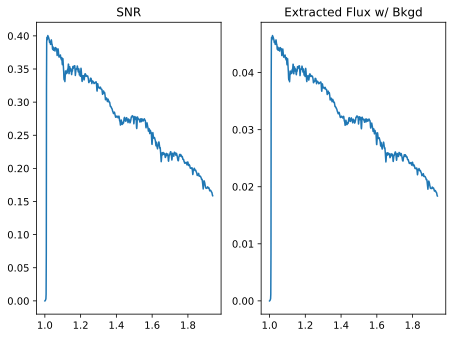

In [26]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(121)
ax2 = fig2.add_subplot(122)
if len(results['1d']['sn'][0]) == 1:
    ax1.scatter(results['1d']['sn'][0],results['1d']['sn'][1])
    ax2.scatter(results['1d']['extracted_flux_plus_bg'][0],results['1d']['extracted_flux_plus_bg'][1])
else:
    ax1.plot(results['1d']['sn'][0],results['1d']['sn'][1])
    ax2.plot(results['1d']['extracted_flux_plus_bg'][0],results['1d']['extracted_flux_plus_bg'][1])
ax1.set_title('SNR')
ax2.set_title('Extracted Flux w/ Bkgd')
fig2.tight_layout()

You can dump the calculation to a file (JSON format, which Python's json module can reconstruct into a dictionary) by running the following cell, and then copying the contents into a file.

In [27]:
print(json.dumps(calc, sort_keys=True, indent=4, separators=(',', ': ')))

{
    "background": "minzodi",
    "background_level": "benchmark",
    "calculation": {
        "effects": {
            "saturation": null
        },
        "noise": {
            "crs": null,
            "ffnoise": null,
            "scatter": null
        }
    },
    "configuration": {
        "detector": {
            "nexp": 1,
            "ngroup": 13,
            "nint": 1,
            "readout_pattern": "medium8",
            "subarray": "spectroscopy"
        },
        "dynamic_scene": true,
        "instrument": {
            "aperture": "spectroscopy",
            "disperser": "g150",
            "filter": null,
            "instrument": "wfi",
            "mode": "spectroscopy"
        },
        "max_scene_size": 25,
        "scene_size": 5
    },
    "scene": [
        {
            "position": {
                "orientation": 45.0,
                "position_parameters": [
                    "x_offset",
                    "y_offset",
                    "orientation

The saved file can be loaded back into a standalone Python instance (or Python script) and run through the engine.

For instance, if you saved your calculation to a file called input.json: